Data loading

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

file_name = 'cumulative_dataset'
# file_name = 'windowed_30d_dataset'
# file_name = 'windowed_90d_dataset'
# file_name = 'windowed_180d_dataset'
# file_name = 'windowed_365d_dataset'

# TODO: Make this work with ``exp_utils.BASE_PATH``
data_path = f'/workspaces/msc_thesis/data/libraries/npm-libraries-1.6.0-2020-01-12/pull-requests/{file_name}.csv'
df = pd.read_csv(filepath_or_buffer=data_path, header=0)

train, test = train_test_split(df, test_size=0.2)

print(
    f'Training with {len(train)} entries, and testing with {len(test)} entries.')


Training with 1239324 entries, and testing with 309832 entries.


Downsamples the majority class to account for class imbalance.

In [76]:
class_counts = df['DepPRIsMerged'].value_counts()

print(f'{class_counts=}')
class_imbalance = max(class_counts) / min(class_counts)
print(f'Class imbalance: {class_imbalance:.03f}.')

if False:
    from sklearn.utils import resample


    majority = df[df.DepPRIsMerged]
    minority = df[df.DepPRIsMerged == False]

    majority = resample(majority, replace=True,
                        n_samples=len(minority), random_state=0)

    df = pd.concat([majority, minority])

    print(f'Resampled size: {len(df)}.')

class_counts=DepPRIsMerged
True     1200819
False     348337
Name: count, dtype: int64
Class imbalance: 3.447.


Downsamples the dataset in case you set ``sample`` to ``>0``.

In [77]:
sample = -1
if sample > 0:
    train = train.sample(100000)
    print("WARNING: TRAINING WITH SAMPLE!")


Selects predictor features and the dependent feature.

In [85]:
print(f'{df.columns=}')

pr_merged_key = 'DepPRIsMerged'
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]
all_labels = df[pr_merged_key]

used_predictors = [
    'ContHasComments',
    'ContDevSuccessRate',
    'ContLifetime',
    'ContNumCommits',
    'PRCountEco',
    'PRAcceptanceRateEco'
]

print(f'{used_predictors=}')

train_predictors = train[used_predictors]
test_predictors = test[used_predictors]
all_predictors = df[used_predictors]


df.columns=Index(['UUID', 'PR-Source', 'PR-ID', 'User-ID', 'Closed-At', 'DepPRIsMerged',
       'ContLifetime', 'ContHasComments', 'ContNumCommits',
       'ContDevSuccessRate', 'PRCountEco', 'PRAcceptanceRateEco'],
      dtype='object')
used_predictors=['ContHasComments', 'ContNumCommits', 'PRCountEco', 'PRAcceptanceRateEco']


## Random Forest

In [86]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
rf = RandomForestRegressor(100, random_state=0)

rf.fit(train_predictors, train_labels)

predictions = rf.predict(test_predictors)
predictions = [pred >= 0.5 for pred in predictions]

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}')


conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

imbalance_weight = list([1.0 if label else class_imbalance for label in test_labels])
f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
print(f'{f1=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))


Absolute error: 1547413    False
1136979    False
1378810     True
1545810    False
1335088    False
           ...  
567292     False
871299     False
343811     False
1326597    False
901638     False
Name: DepPRIsMerged, Length: 309832, dtype: bool
conf=array([[  4319,  65180],
       [  3832, 236501]])
f1=0.6742449517063099
              precision    recall  f1-score   support

       False       0.80      0.06      0.12 239583.276198404
        True       0.51      0.98      0.67  240333.0

    accuracy                           0.52 479916.276198404
   macro avg       0.65      0.52      0.39 479916.276198404
weighted avg       0.65      0.52      0.40 479916.276198404



Generates partial dependence plots.

It's visible that the intra-project experience completely overshadows other factors. 

When exclusing this, you can see that PR acceptance ratio matters as well as whether the PR has comments. 
Lifetime somehow has no effect whatsoever; ditto for the ecosystem PR count. 

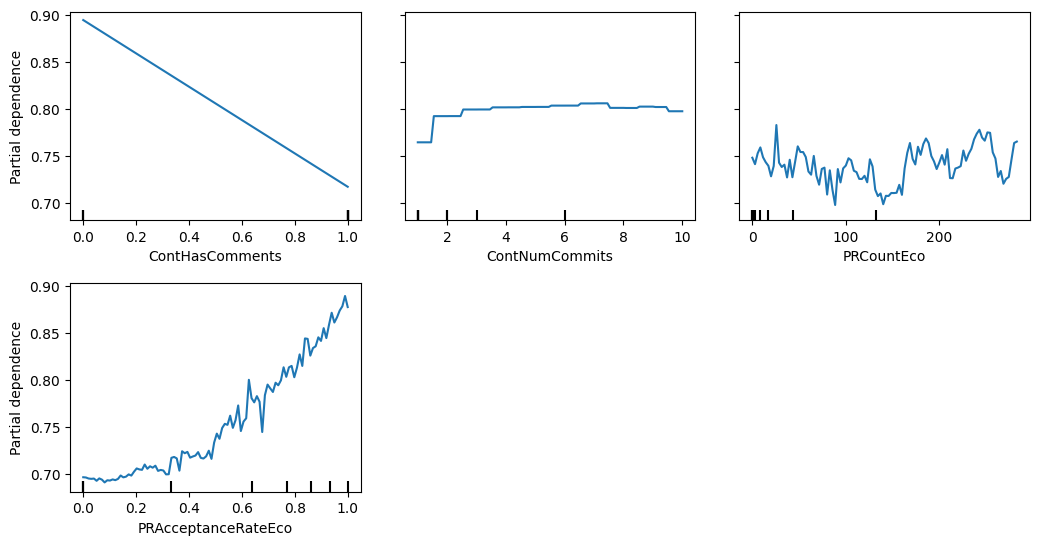

In [87]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

# Collective partial dependence plot.
PartialDependenceDisplay.from_estimator(rf, test_predictors, used_predictors)

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(6)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.15,
                    hspace=0.3)


In [88]:
# Disabled as this takes forever.
# # Individual partial dependence plot.
# PartialDependenceDisplay.from_estimator(
#     rf, test_predictors, used_predictors, kind='individual')

# fig = plt.gcf()
# fig.set_figwidth(12)
# fig.set_figheight(6)
# fig.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.15,
#                     hspace=0.3)


## Logistic Regression

In [89]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_predictors, train_labels)

lr_predictions = lr.predict(test_predictors)

imbalance_weight = [1.0 if label else class_imbalance for label in test_labels]
score = lr.score(test_predictors, test_labels, imbalance_weight)

print(f'{score=}')

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}')


conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
print(f'{f1=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))

score=0.5030279274618473
Absolute error: 1547413    False
1136979    False
1378810     True
1545810    False
1335088    False
           ...  
567292     False
871299     False
343811     False
1326597    False
901638     False
Name: DepPRIsMerged, Length: 309832, dtype: bool
conf=array([[  4319,  65180],
       [  3832, 236501]])
f1=0.6742449517063099
              precision    recall  f1-score   support

       False       0.80      0.06      0.12 239583.276198404
        True       0.51      0.98      0.67  240333.0

    accuracy                           0.52 479916.276198404
   macro avg       0.65      0.52      0.39 479916.276198404
weighted avg       0.65      0.52      0.40 479916.276198404



Calculates corresponding p-values for each feature.

In [90]:
import statsmodels.api as sm

has_comments_key = 'ContHasComments'
if has_comments_key in used_predictors:
    value_mapper = {False: 0, True: 1}
    train_predictors[has_comments_key] = train_predictors[has_comments_key].replace(value_mapper)
    test_predictors[has_comments_key] = test_predictors[has_comments_key].replace(value_mapper)
    
sm_lr = sm.Logit(train_labels, train_predictors[used_predictors])
result = sm_lr.fit()

print(result.params)

predictions = result.predict(test_predictors[used_predictors])
predictions = [pred >= 0.5 for pred in predictions]

result.pred_table()

print('summary 1:')
result.summary()

print('summary 2:')
result.summary2()


/tmp/ipykernel_52309/1709656433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_predictors[has_comments_key] = train_predictors[has_comments_key].replace(value_mapper)
/tmp/ipykernel_52309/1709656433.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_predictors[has_comments_key] = test_predictors[has_comments_key].replace(value_mapper)


Optimization terminated successfully.
         Current function value: 0.546643
         Iterations 6
ContHasComments        0.203451
ContNumCommits        -0.001312
PRCountEco             0.001055
PRAcceptanceRateEco    1.675227
dtype: float64
summary 1:
summary 2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit            Pseudo R-squared: -0.025      
Dependent Variable:  DepPRIsMerged    AIC:              1354942.3783
Date:                2023-04-27 15:19 BIC:              1354990.4986
No. Observations:    1239324          Log-Likelihood:   -6.7747e+05 
Df Model:            3                LL-Null:          -6.6075e+05 
Df Residuals:        1239320          LLR p-value:      1.0000      
Converged:           1.0000           Scale:            1.0000      
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
ContHasComments      0.2035   0.0030  67.5514 0.0000  0.1975  0.2094
ContNumCommits      -0.0013   0.0001 -21.1251 0.0000 -0.0014 -0.0012
PRCountEco           0.0011   0.0000  48.3060 0.0000  0.0010  0.0011
PRAcceptanceRateEco  1.6752   0.0048 347.5838 0.0000  1.6658  1.6847
====================================================================

"""